![](pics/header.png)

# Stereo Model and Camera Calibration

Kevin J. Walchko, Phd

20 Nov 2018

Stereo Vision is utilizing 2 (or more) pinhole cameras. We typically use a similar model to explaine geometry, but since we have more than one camera, we can get depth (z-direction) information.

## References

- [1] camera.pdf
- [2] [Multiple View Geometry in Computer Vision
Second Edition](http://www.robots.ox.ac.uk/~vgg/hzbook/hzbook2/HZepipolar.pdf)
- [3] [CSE486, lecture 19](http://www.cse.psu.edu/~rtc12/CSE486/lecture19.pdf)
- wikipedia: [Fundamental Matrix (F)](https://en.wikipedia.org/wiki/Fundamental_matrix_(computer_vision))
- wikipedia: [Essential Matrix (E)](https://en.wikipedia.org/wiki/Essential_matrix)
- github: [StereoVision](https://github.com/erget/StereoVision)
- github: [steroid](https://github.com/sebastian-tschen/stereoids)
- github: [OpenCV Python Tutorials](https://github.com/opencv/opencv/tree/master/doc/py_tutorials)
- gist: [Adhoc AR Tracker for Planar Scenes](https://gist.github.com/royshil/7087bc2560c581d443bc#file-simpleadhoctracker-cpp-L101)
- github.io: [Stereo Calibration Demo](http://amroamroamro.github.io/mexopencv/opencv/stereo_calibration_demo.html)
- ROS: [Choosing Good Stereo Parameters](http://wiki.ros.org/stereo_image_proc/Tutorials/ChoosingGoodStereoParameters)
- sourishghosh: [Stereo Calibration using C++](https://sourishghosh.com/2016/stereo-calibration-cpp-opencv/)
- sourishghosh: [Calculating the Fundamental Matrix](https://sourishghosh.com/2016/fundamental-matrix-from-camera-matrices/)
- kushalvyas: [Demystifying Geometrix Camera Calibration](https://kushalvyas.github.io/calib.html)
- GeorgiaTech: [CS4476: Camera Calibration and Fundamental Matrix](https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj3/html/xyuan39/index.html)
- CalTech: [Matlab Camera Calibration Toolbox](http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/example5.html)

# Calibrating Stereo Cameras

We will look a calibrating a stereo camera using the standard chessboard pattern.

![](pics/stereo.png)

We need to estimate some camera parameters, both internal and external. Basic process:

1. For a series of images, use `cv2.findMarkers()` to find your calibration target's pattern (`objpts`) in the image (`imgpts`) for each gray scale image
    - `objpts` are how the features exist in the 3D world
    - `imgpts` are how the *same* features appear in the 2D image
1. You can use `cv2.cornerSubPix()` to refine your results
    - Sometimes this degrades the results instead of improves them
1. Use `cv2.calibrateCamera()` to get the left/right camera intrinsic parameters
    - You will run this twice, once on each camera
    - The key results are the camera matrix (K) and the distortion coefficients (d) for each
1. Use `cv2.stereoCalibrate()` to get the system extrinsic parameters
    - **Rotation (R):** How the right camera is rotated relative to the left camera
    - **Translation (T):** The distance the right camera is from the left camera (units will be meters, centimeters, milimeters, etc)
    - **Essential Matrix (E):** contains the information about translation and rotation between the 2 cameras in global coordinates.
    - **Fundamental Matrix (F):** contains the same information as E, but also contains intrinsics of both cameras so that we can relate the two cameras in pixel coordinates.
    
Now we have a set of parameters:

- Camera matrix: K1, K2
- Projection matrix:
    - Left: $P1 = K1 [I|0]$
    - Right: $P2 = K2 [R|T]$
- Fundamental matrix[2]: $F = K2^{-T}RK1^T [K1 R^T t]_x$ where $[]_x$ is the skew matrix
    - Uses **image coordinates** both the intrinsics and extrinsics
    - Derivation found in [2](http://www.robots.ox.ac.uk/~vgg/hzbook/hzbook2/HZepipolar.pdf) Table 9.1, bottom
- Essential matrix
    - $E = R [R^T t]_x$
    - Can also be found from: $E = K2^T F K1$ [2, eqn 9.12]
    - Uses **camera coordinate** and only needs the extrinsics

## Epipolar Lines

![](pics/epipolar_geometry.png)

Stereo matching generally utilizes searching across epipolar lines for features that match. This helps to greatly reduce the search space and speed things up. The essential and fundamental matricies encode the epipolar geometery between two views of the same objects. An epipolar line:

$$
au+bv+c=0 \\
p = \begin{bmatrix} u & v & 1 \end{bmatrix}^T \\
l = \begin{bmatrix} a & b & c \end{bmatrix}^T \\
p^Tl = l^Tp = 0
$$

It turns out we can use these equations for epipolar lines and subtitute in $E$ or $F$.

$$
p^T_1 l_1 = p^T_1 E p_2 = 0
$$

where $p_1$ a point in the left camera and $p_2$ is a point in the right camera.

Like F, E carries knowledge of the stereo setup, but it exists in normalized space, not pixel space.

$$
\begin{eqnarray}
    \hat x' = R(\hat x -T) \\
    E = R[t]_x \\
    [t]_x = \begin{bmatrix} 
        0    & -T_z & T_y \\
        T_z  & 0    & -T_x \\
        -T_y & T_x  & 0
    \end{bmatrix}
\end{eqnarray}
$$

Given image points in both cameras (with noise), the E can be estimated using a total least squares approach. This approach is commonly referred to as the [eight-point-algorithm](https://en.wikipedia.org/wiki/Eight-point_algorithm)

See [CSE486 [3]](http://www.cse.psu.edu/~rtc12/CSE486/lecture19.pdf) for examples of finding $F$ and calculating epipolar lines.

## Rectifying Images

![](pics/stereo_undistort.jpg)

During camera manufacturing, small mechanical misalignments are produced which can effect stereo performance. To fix the image and make straight lines (think epipolar lines) straight again:

- `cv2.stereoRectify()` to produce necessary matricies
- Create distortion maps using `cv2.initUndistortRectifyMap()` for the left/right camera
- Undistort an image using `cv2.remap()` and the products from the above functions. The good thing, though, is the first 2 function can be called once so you have everything. Then, during run-time, you can just use `cv2.remap()`

## Calculating Disparity Maps

![](pics/disparity-2.png)

Objects closer to the stereo cameras will have larger disparity, meaning they will be found in different places in the two images. Conversly, objects farther way will have smaller disparity and will be found roughly in the same row/column of both images.

![](pics/disparity.png)

Stereo models like `cv2.StereoSGBM` or `cv2.StereoBM` can be used to find corresponding points in the image pair (left and right) and calculate the disparity between them (number of pixels). Instead of matching individual pixels, the stereo models tend to match blocks of pixels.

### Basic process

1. Rectify images to ensure epipolar constraint
1. Find features in both individual images
1. Match each feature in the left image to a feature in the right image
    - You don't want to search the entire image, takes too much time
    - Reduce search by looking along epipolar lines
1. (see image above) Given feature at p(x,y) in the left image
    - Start at the minimum disparity (matcher parameter) and move left along epipolar line until you:
        - Find a match and record the distance ($p_{right} - p_{left}$)
            - Sometimes the syntax $x - x'$ is used for disparity
        - Or hit the maximum disparity (matcher parameter) and give up  for that feature
            - `NaN` means the feature couldn't be matched
        - Iterate across all features
1. Filter out bad matches that result in error (i.e., $disp \le 0$)
    - Valid numbers range from disparity.min() to (disparity.min()+numDisparities)

### Block Matching (BM)

OpenCV 3.4 docs: [ref](https://docs.opencv.org/3.4.0/d9/dba/classcv_1_1StereoBM.html) 

The class computing stereo correspondence using the block matching algorithm, introduced and contributed to OpenCV by K. Konolige. Stereo algorithms tend not to match points (which is what the math above leads you to believe) but rather they match square blocks of pixels (e.g., 5x5, 7x7).

#### Params

- **numDisparities:** the disparity search range. For each pixel algorithm will find the best disparity from 0 (default minimum disparity) to numDisparities. The search range can then be shifted by changing the minimum disparity.
- **blockSize:** the linear size of the blocks compared by the algorithm. The size should be odd (as the block is centered at the current pixel). Larger block size implies smoother, though less accurate disparity map. Smaller block size gives more detailed disparity map, but there is higher chance for algorithm to find a wrong correspondence.

### Semi Global Block Matching (SGBM)

OpenCV 3.4 docs: [ref](https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html#details)

The class implements the modified H. Hirschmuller algorithm that differs from the original one as follows:

- By default, the algorithm is single-pass, which means that you consider only 5 directions instead of 8. Set `mode=StereoSGBM::MODE_HH` in `StereoSGBM_create` to run the full variant of the algorithm but beware that it may consume a lot of memory.
- The algorithm matches blocks, not individual pixels. Though, setting blockSize=1 reduces the blocks to single pixels.
- Mutual information cost function is not implemented. Instead, a simpler Birchfield-Tomasi sub-pixel metric from is used. Though, the color images are supported as well.
- Some pre- and post- processing steps from K. Konolige algorithm StereoBM are included, for example: pre-filtering (`StereoBM::PREFILTER_XSOBEL` type) and post-filtering (uniqueness check, quadratic interpolation and speckle filtering).

#### Params

- **minDisparity:**	Minimum possible disparity value. Normally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.
- **numDisparities:**	Maximum disparity minus minimum disparity. The value is always greater than zero. In the current implementation, this parameter must be divisible by 16.
- **blockSize:**	Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
- **P1:**	The first parameter controlling the disparity smoothness. See below.
- **P2:**	The second parameter controlling the disparity smoothness. The larger the values are, the smoother the disparity is. P1 is the penalty on the disparity change by plus or minus 1 between neighbor pixels. P2 is the penalty on the disparity change by more than 1 between neighbor pixels. The algorithm requires P2 > P1 . See stereo_match.cpp sample where some reasonably good P1 and P2 values are shown, like:
    - P1: $8 \cdot numberImageChannels \cdot SADWindowSize \cdot SADWindowSize$
    - P2: $32 \cdot numberImageChannels \cdot SADWindowSize \cdot SADWindowSize$
    - where SAD is sum of absolute difference
- **disp12MaxDiff:**	Maximum allowed difference (in integer pixel units) in the left-right disparity check. Set it to a non-positive value to disable the check.
- **preFilterCap:**	Truncation value for the prefiltered image pixels. The algorithm first computes x-derivative at each pixel and clips its value by [-preFilterCap, preFilterCap] interval. The result values are passed to the Birchfield-Tomasi pixel cost function.
- **uniquenessRatio:**	Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct. Normally, a value within the 5-15 range is good enough.
- **speckleWindowSize:**	Maximum size of smooth disparity regions to consider their noise speckles and invalidate. Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
- **speckleRange:**	Maximum disparity variation within each connected component. If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16. Normally, 1 or 2 is good enough.
- **mode:**	Set it to `StereoSGBM::MODE_HH` to run the full-scale two-pass dynamic programming algorithm. It will consume O(W\*H\*numDisparities) bytes, which is large for 640x480 stereo and huge for HD-size pictures. By default, it is set to `False`.

## How to Get Good Disparity Map

1. Scene needs enough detectable and distinguishable features between image pairs
1. Need features appropriate for baseline
    - Features too close won't be seen in both images
    - Features too far will be reported as same pixel

# Calibration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # set default figure width

from slurm import storage
from pprint import pprint
from pathlib import Path

In [5]:
import opencv_camera as oc
from opencv_camera import CameraCalibration
from opencv_camera import StereoCalibration
from opencv_camera import ChessboardFinder
from opencv_camera import UnDistort
from opencv_camera import bgr2gray, gray2bgr
from opencv_camera import drawEpipolarLines
from opencv_camera import coverage, mosaic
from opencv_camera import stereoOverlay

In [7]:
def readImages(pattern):
    p = Path("cal_pics").glob(pattern)
    p = list(p)
    p.sort()
    return [cv2.imread(str(f),0) for f in p]

imgL = readImages("left*.jpg")
imgR = readImages("right*.jpg")

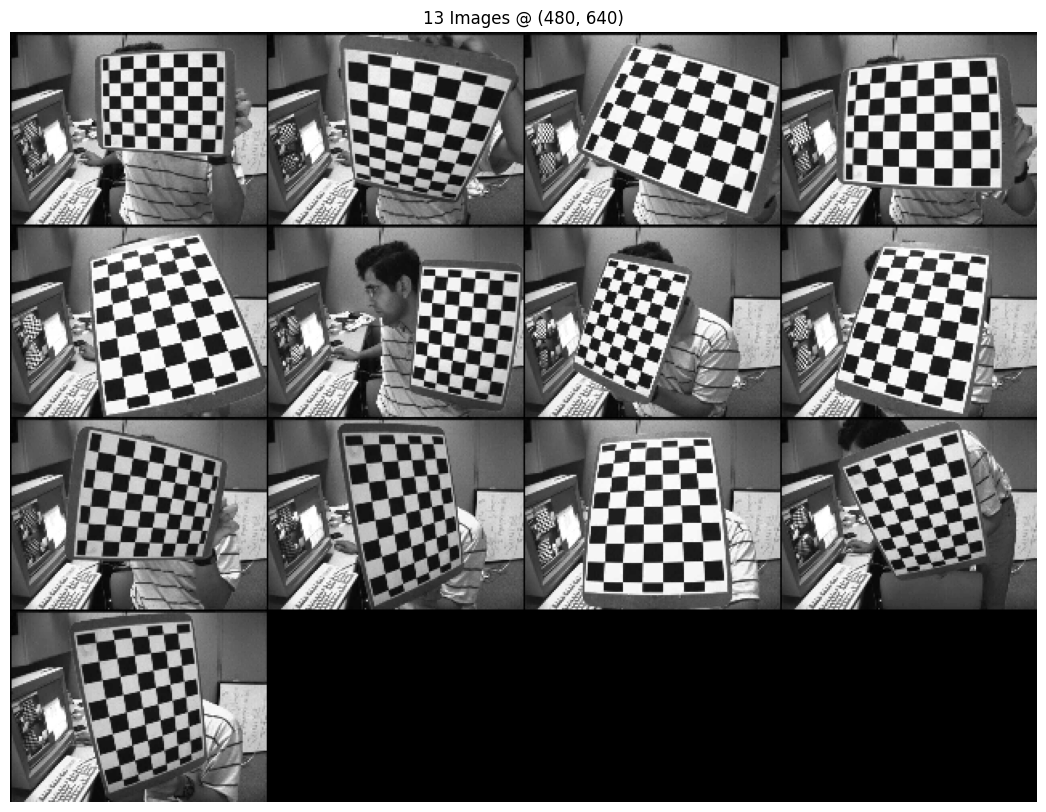

In [24]:
# a simple mosasic of the various images
plt.imshow(mosaic(imgL, width=4), cmap="gray")
plt.title(f"{len(imgL)} Images @ {imgL[0].shape}")
plt.axis("off");

In [11]:
stereoCal = StereoCalibration()
board = ChessboardFinder((9,6), 1)

ok, cm, sc = stereoCal.calibrate(imgL, imgR, board)

>> RMS: 0.195px

 Camera[480,640]----------------------
  focalLength(x,y): 532.8 532.9 px 
  principlePoint(x,y): 342.5 233.9 px
  distortionCoeffs: [[-0.281  0.025  0.001 -0.     0.163]]

>> RMS: 0.207px

 Camera[480,640]----------------------
  focalLength(x,y): 537.5 537.0 px 
  principlePoint(x,y): 327.6 248.9 px
  distortionCoeffs: [[-0.298  0.15  -0.001  0.    -0.066]]

Object Pts: 13
Left Image Pts: 13
Right Image Pts: 13


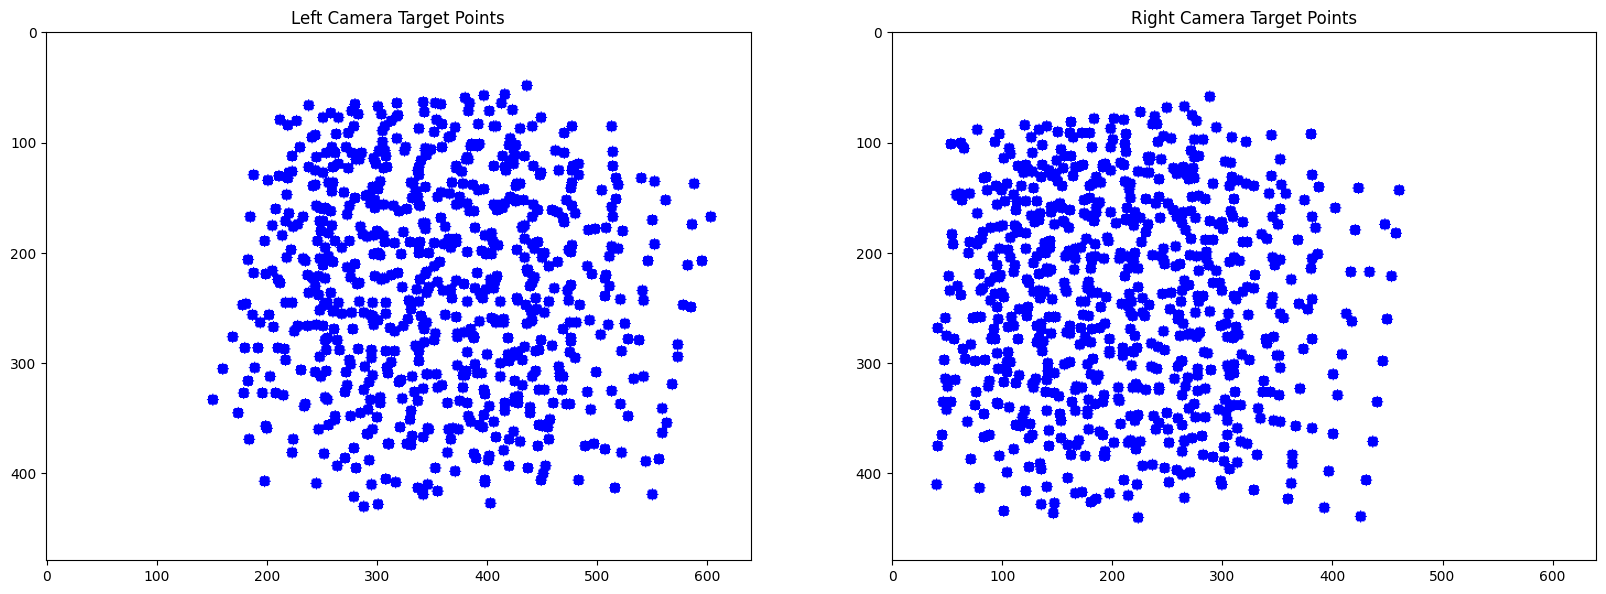

In [12]:
# let's plot where every corner was detected. Notice
# we are not testing the edges of the camera! That 
# is where a lot of distortion occurs from low quality
# lenses. Ideally, you want better coverage.
plt.subplot(1,2,1)
ip = cm["imgpointsL"]
icv = coverage((480, 640), ip)
plt.imshow(icv)
plt.title("Left Camera Target Points");

plt.subplot(1,2,2)
ip = cm["imgpointsR"]
icv = coverage((480, 640), ip)
plt.imshow(icv)
plt.title("Right Camera Target Points");

In [23]:
print(sc)
sc.to_yaml("camera.yml")

Camera 1 --------------------------
  focalLength(x,y): 533.4 533.4 px 
  principlePoint(x,y): 342.5 234.7 px
  distortionCoeffs: [[-0.282  0.039  0.001 -0.     0.119]]
Camera 2 --------------------------
  focalLength(x,y): 537.0 536.6 px 
  principlePoint(x,y): 327.4 249.9 px
  distortionCoeffs: [[-0.296  0.139 -0.001  0.    -0.049]]
Extrinsic Camera Parameters -------
  Translation between Left/Right Camera: [[-3.327]
 [ 0.037]
 [-0.005]]
  Rotation between Left/Right Camera:
    [[ 1.     0.004  0.004]
     [-0.004  1.    -0.007]
     [-0.004  0.007  1.   ]]
  Essential Matrix:
    [[-0.     0.005  0.037]
     [-0.019  0.024  3.327]
     [-0.025 -3.327  0.024]]
  Fundatmental Matrix:
    [[ 0.    -0.    -0.001]
     [ 0.    -0.    -0.092]
     [ 0.     0.093  1.   ]]



In [6]:
# See the answer from OpenCV Tutorials
# this is the answer they came up with
ans = cv2.FileStorage("cal_pics/intrinsics.yml", cv2.FILE_STORAGE_READ)
print("Left camera K1 and D1")
print("-"*40)
print(ans.getNode("M1").mat())
print(ans.getNode("D1").mat())
print("")
print("Right camera K2 and D2")
print("-"*40)
print(ans.getNode("M2").mat())
print(ans.getNode("D2").mat())

Left camera K1 and D1
----------------------------------------
[[534.803   0.    335.686]
 [  0.    534.803 240.662]
 [  0.      0.      1.   ]]
[[ 0.296 -1.035  0.     0.     0.   ]]

Right camera K2 and D2
----------------------------------------
[[534.803   0.    334.557]
 [  0.    534.803 242.053]
 [  0.      0.      1.   ]]
[[-0.169 -0.112  0.     0.     0.   ]]


In [17]:
h,w = imgL[0].shape
ud = sc.getUndistortion(h, w)

num = 3
cl, cr = ud.undistort(imgL[num], imgR[num])
corr = drawEpipolarLines(cm["imgpointsL"],cm["imgpointsR"],cl,cr)
plt.imshow(corr, cmap="gray")
plt.title(f"{corr.shape}");

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/calib3d/src/fundam.cpp:854: error: (-5:Bad argument) The input arrays should be 2D or 3D point sets in function 'findFundamentalMat'


In [18]:
# from opencv_camera.stereo.utils import computeF

# # calculated from opencv
# print("OpenCV:")
# print(sc.F)

# # come up with the same normalized F matrix as OpenCV
# print("\ncomputeF:")
# ee = computeF(sc.K1, sc.K2, sc.R, sc.T)
# print(ee)

## Rectification with `cv2.stereoRectify()`

In [19]:
r1,r2,p1,p2,q,roi1,roi2 = cv2.stereoRectify(
    sc.K1,sc.d1,
    sc.K2,sc.d2,
    (480,640),
    sc.R,sc.T,
    flags=cv2.CALIB_ZERO_DISPARITY)
print(r1,"\n---------")
print(r2,"\n---------")
print(p1,"\n---------")
print(p2,"\n---------")
print(q,"\n---------")
print(f"left: {roi1}   right: {roi2}")

[[ 1.    -0.008  0.006]
 [ 0.008  1.    -0.004]
 [-0.006  0.004  1.   ]] 
---------
[[ 1.    -0.011  0.001]
 [ 0.011  1.     0.004]
 [-0.001 -0.004  1.   ]] 
---------
[[535.022   0.    343.639   0.   ]
 [  0.    535.022 235.731   0.   ]
 [  0.      0.      1.      0.   ]] 
---------
[[  535.022     0.      343.639 -1780.16 ]
 [    0.      535.022   235.731     0.   ]
 [    0.        0.        1.        0.   ]] 
---------
[[   1.       0.       0.    -343.639]
 [   0.       1.       0.    -235.731]
 [   0.       0.       0.     535.022]
 [   0.       0.       0.301   -0.   ]] 
---------
left: (0, 0, 480, 640)   right: (14, 0, 466, 623)


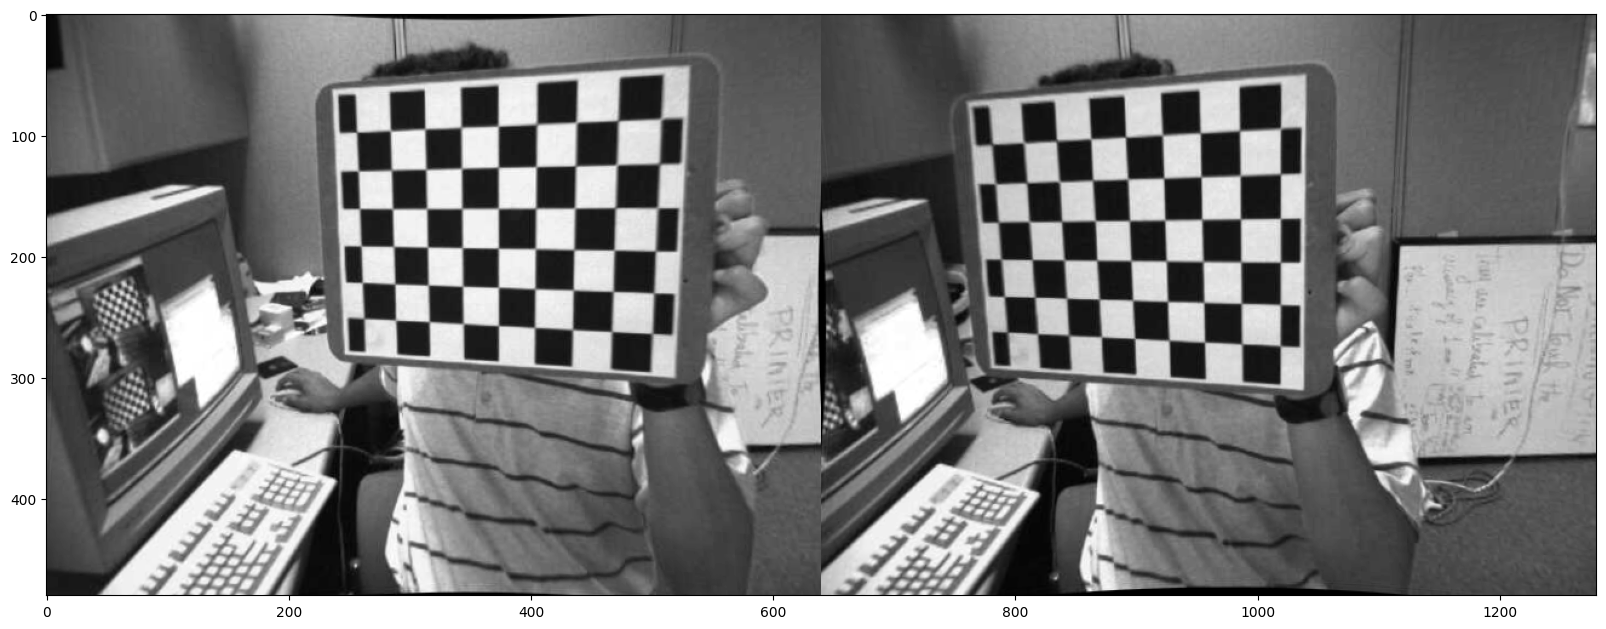

In [21]:
num = 0
ll,rr = ud.undistort(imgL[num],imgR[num])
cc = np.hstack((ll,rr))

plt.imshow(cc, cmap="gray");

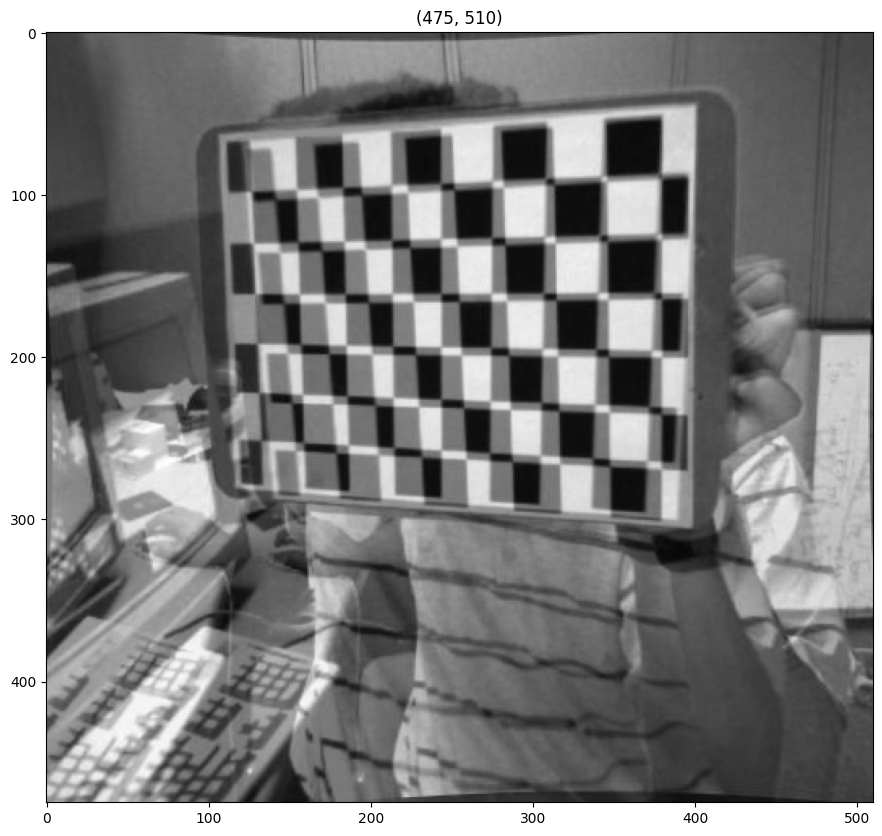

In [22]:
# for fun, let's overlay the images and adjust to get an idea
# of how well the retification worked ... it won't be perfect
# depending on setup of the cameras and collection. Also 
# remember, we already pointed out the entire image plane was
# not covered with target features (corners).
tmp = stereoOverlay(ll, rr, 130,-5)
plt.imshow(tmp, cmap="gray")
plt.title(f"{tmp.shape}");